In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.stats import pearsonr
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy

In [3]:
# 
# Input data are in individual tab-delimited files, one for each experiment
# Here I load each one into its own Pandas dataframe and create a list of frames
#

frames = []

for file in os.listdir("Data"):
    if file.endswith(".gbgout"):
        filepath = os.path.join("Data/", file)
        fs = file.split('_')
        name = "_".join(fs[0:2])
        frames.append(pd.read_csv(filepath, sep="\t", header = None, names=['Gene',name]))

In [4]:
#
# This combines all of the individual frames into one dataframe, combining on the "Gene" column
#

df = reduce(lambda  left,right: pd.merge(left,right,on=['Gene'], how='outer'), frames)

In [5]:
#
# Sort columns by name
#

df = df.reindex_axis(sorted(df.columns), axis=1)

In [6]:
#
# Use only genes starting with "Y" which are protein-coding genes
#

df = df.loc[df['Gene'].str.startswith('Y')]

In [7]:
#
# Index dataframe on 'Gene'
#

df = df.set_index('Gene')

In [8]:
# Save

df.to_csv("Barton_combined_Ygenes.txt", sep='\t')

The paper discusses problems with individual samples. One way to screen for this in a sample that's so large is to look within the two sets for outliars.

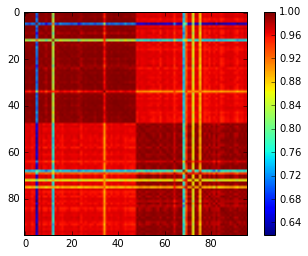

In [9]:
colnames = df.columns.get_values()

corrdata = np.zeros( (len(colnames),len(colnames)))

for i1,c1 in enumerate(colnames):
    d = []
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
plt.imshow(corrdata)
plt.colorbar()

Can see from plot about that there are several problematic samples that have correlations that are outliars. How should we filter them? Simplest way would be to pick an average correlation to other samples as a cutoff. What should we choose? 

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   1.,   0.,   1.,   1.,   0.,   2.,  89.]),
 array([ 0.5  ,  0.525,  0.55 ,  0.575,  0.6  ,  0.625,  0.65 ,  0.675,
         0.7  ,  0.725,  0.75 ,  0.775,  0.8  ,  0.825,  0.85 ,  0.875,
         0.9  ,  0.925,  0.95 ,  0.975]),
 <a list of 19 Patch objects>)

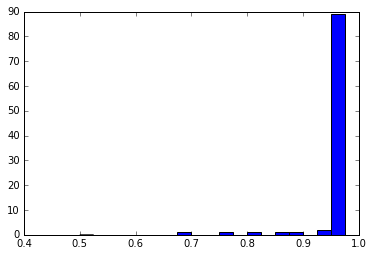

In [10]:
#
# Make a histogram of average correlation values
#

corrmeans = []
for i1,c1 in enumerate(corrdata):
    corrmeans.append(np.mean(c1))

plt.hist(corrmeans, bins=np.arange(0.5,1.0,.025))

Most are above .95 so let's make that our cutoff

In [11]:
colnames_filt = []
for c1 in colnames:
    d = []
    for c2 in colnames:
        d.append(pearsonr(df[c1],df[c2])[0])
    d = np.array(d)
    if np.mean(d) < 0.95:
        print ("Removing ",c1,np.mean(d))
    else:
        colnames_filt.append(c1)
        
colnames = colnames_filt

Removing  Snf2_rep06 0.691487784223
Removing  Snf2_rep13 0.803427905697
Removing  Snf2_rep35 0.932471392569
Removing  WT_rep21 0.764104671143
Removing  WT_rep22 0.933839516889
Removing  WT_rep25 0.86363576014
Removing  WT_rep28 0.891720439048


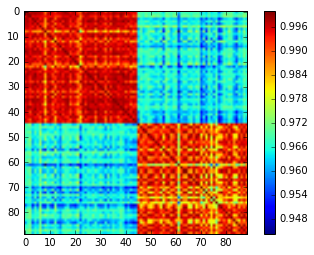

In [12]:
# now replot 

corrdata = np.zeros( (len(colnames),len(colnames)))

for i1,c1 in enumerate(colnames):
    d = []
    for i2,c2 in enumerate(colnames):
        corrdata[i1][i2] = pearsonr(df[c1],df[c2])[0]
        
plt.imshow(corrdata)
plt.colorbar()

Still some heterogeneity but looks a lot better - no egregious outliars - so we'll use this set

In [13]:
# now create lists for WT and Snf2

colnames_snf2 = []
colnames_WT = []

for c in colnames:
    if c.startswith("Snf2"):
        colnames_snf2.append(c)
    elif c.startswith("WT"):
        colnames_WT.append(c)

In [14]:
# create new columns that are averages

df['Snf2_ave'] = df[colnames_snf2].mean(axis=1)
df['WT_ave'] = df[colnames_WT].mean(axis=1)
df['ave'] = df[colnames_snf2 + colnames_WT].mean(axis=1)

Exercise 1: 

Let's imagine we did an experiment with no replicates - one sample per consdition. 

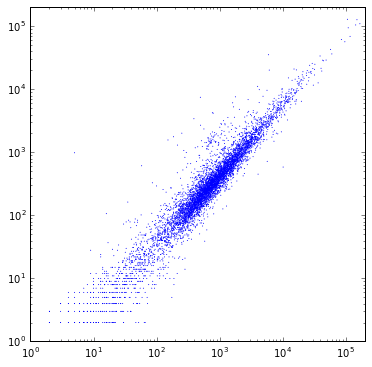

In [17]:
# let's pick a pair of WT and snf2 experiments and see how they compare

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)

ax.scatter(x, y, s = 1, c='b', edgecolor = 'none')


can already see a problem which is doesn't look like data fall along line x = y

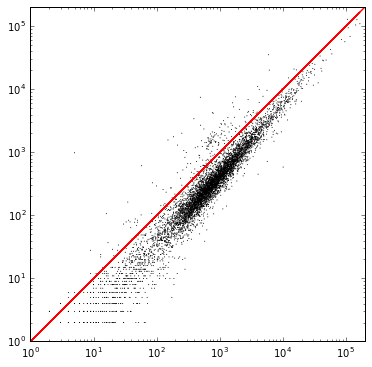

In [25]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Yikes!! Data should fall along line. We will return to this issue in a little bit but for now let's try another pair of samples.'

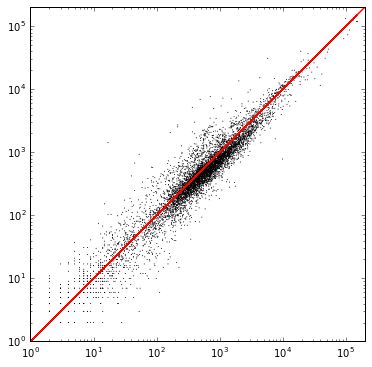

In [26]:
# let's pick a pair of WT and snf2 experiments and see how they compare

# how well do these fit?

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Not perfect, but a lot better. So now, how do we identify outliers? Many people start by saying genes up or down 2x. So let's look at those.

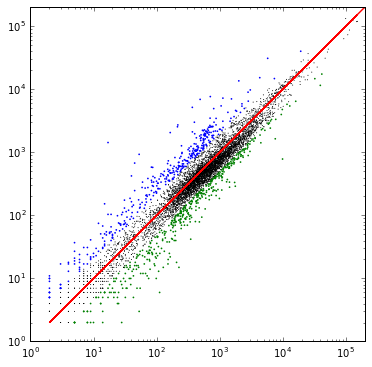

In [29]:
# let's pick a pair of WT and snf2 experiments and see how they compare

c1 = 'Snf2_rep02'
c2 = 'WT_rep02'

# select data, remove really low values

x = df[c1][(df[c1] > 1) & (df[c2] > 1)] # throw out really small values
y = df[c2][(df[c1] > 1) & (df[c2] > 1)]

# set color and size of points based on X/Y ratio

c = []
s = []

for i,vx in enumerate(x):    
    if x[i]/y[i] > 2.0:
        c.append('g')
        s.append(3)
    elif x[i]/y[i] < .5:
        c.append('b')
        s.append(3)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposx='clip')
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
ax.plot(x,x,'r-')

That's quite a lot of points! Should we believe them? Fortunately we can sanity check this because we actually have a lot more data. Let's start by comparing the Snf2/WT ratio in this pair of samples to a different pair. 

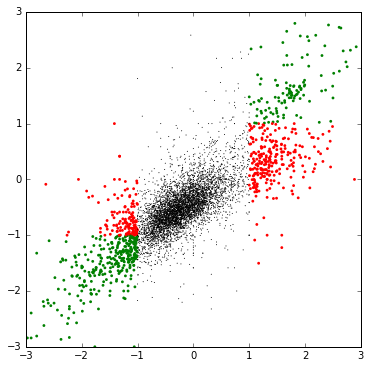

In [55]:
wt1 = 'WT_rep02'
wt2 = 'WT_rep03'
mut1 = 'Snf2_rep02'
mut2 = 'Snf2_rep03'

cols = [wt1,wt2,mut1,mut2]

# create a temporary data frame where any row with values < 1 are removed

tdf = df[cols][df > 1].dropna()

x = np.log2(tdf[wt1]/tdf[mut1])
y = np.log2(tdf[wt2]/tdf[mut2])

c = []
s = []

for i,vx in enumerate(x):    
    if x[i] > 1.0: 
        if y[i] > 1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    elif x[i] < -1.0:
        if y[i] < -1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
#ax.plot(x,x,'r-')

Clearly we need more than just one or two samples to accurately identify reproducible differences between samples. But how many do we need?

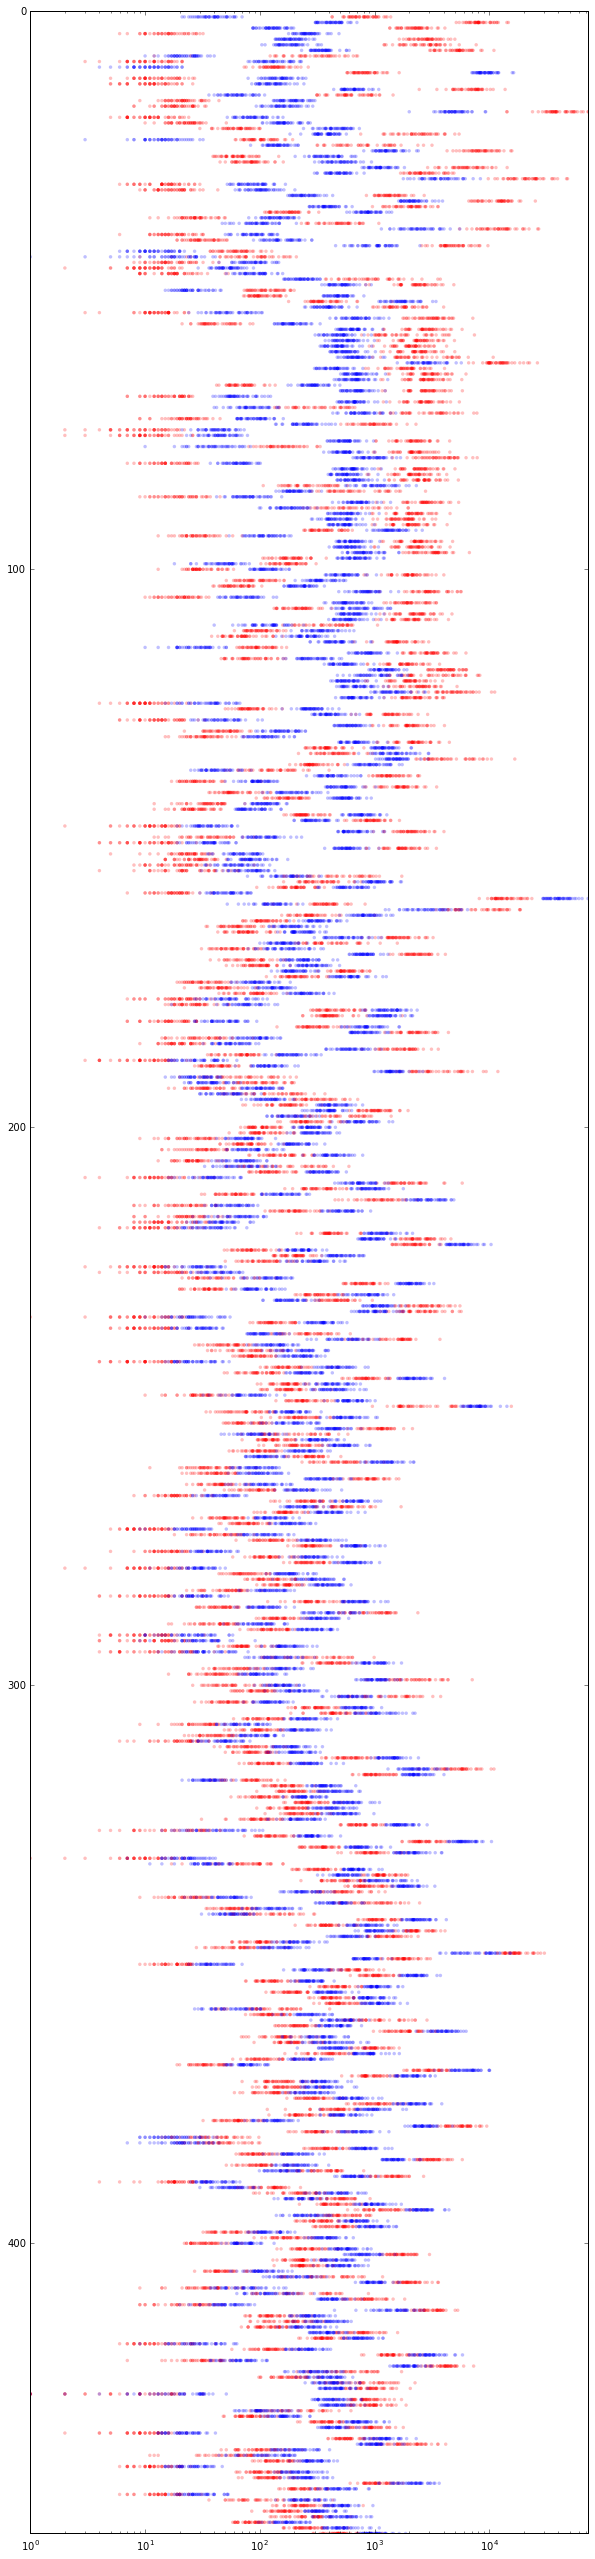

In [68]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['WT_ave','Snf2_ave']
tdf = df[cols][df > 10].dropna()

for index, row in tdf.iterrows():
    snf2 = row['Snf2_ave']
    wt = row['WT_ave']
    aved[index] = abs(np.log2(snf2/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(max(wt_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=12,alpha=.25,c='b',edgecolor='none')

In [89]:
# Sort based K-S

ksv = {}

cols = ['WT_ave','Snf2_ave']

for index, row in df.iterrows():
    snf2 = row[colnames_snf2]
    wt = row[colnames_WT]
    ksv[index] = -np.log10(ks_2samp(wt,snf2)[1])

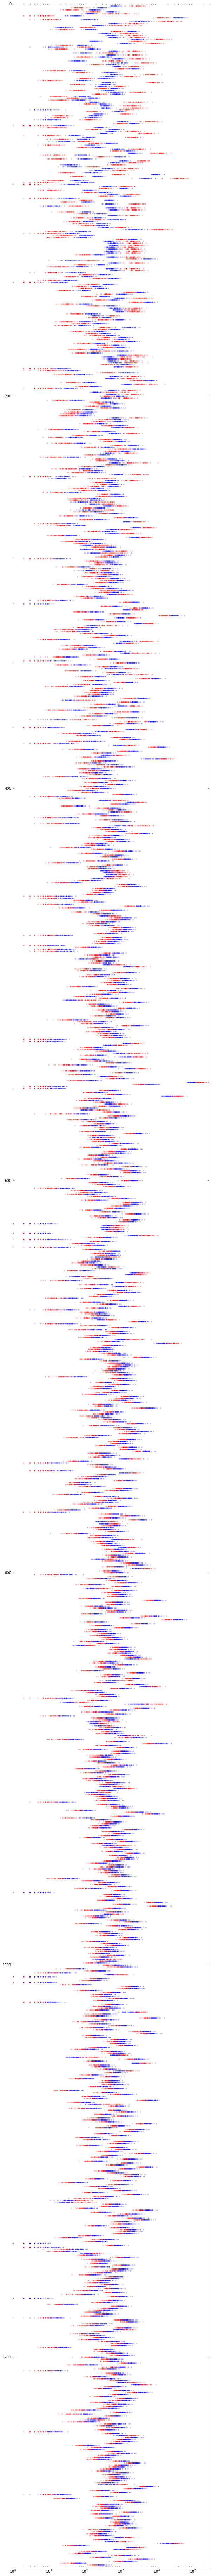

In [91]:
ksv = {k:v for (k,v) in ksv.items() if v > 10.0}

ksvs = sorted(ksv.keys(),key = lambda x: ksv[x], reverse=True)

snf2_ind = []
snf2 = []
wt_ind = [] 
wt = []

for i,t in enumerate(ksvs):
    for c in colnames_snf2:
        snf2_ind.append(i+1)
        snf2.append(df.at[t,c])
    for c in colnames_WT:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + snf2))
ax.set_ylim(max(wt_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(snf2,snf2_ind,s=12,alpha=.25,c='b',edgecolor='none')